## Pytorch Computer Vision

## 0. Computer vision libraries in PyTorch 

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for CV
* `torchvision.models` - get pretrained computer vision models
* `torchvision.transforms` - functions for manipulation vision data for use in an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [114]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision 
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import torchmetrics
import torchmetrics

# Import plotting libraries
import matplotlib.pyplot as plt
import mlxtend

# Other imports
import requests
from pathlib import Path
import pandas as pd
import random

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Check version
print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)
print(mlxtend.__version__)
print(device)

2.5.1
0.20.1
1.6.0
0.23.3
mps


## 1. Getting a dataset

We will be using FashionMNIST

In [54]:
train_data = datasets.FashionMNIST(
    root="data", #save here
    train=True, #get the training dataset
    download=True, #download it
    transform=torchvision.transforms.ToTensor(), #transform dataset with this method
    target_transform=None #no transform for the target labels
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

len(train_data), len(test_data)

(60000, 10000)

### 1.1 Check dimensions of our data

In [55]:
image, label = train_data[0]
class_names = train_data.classes

print(f"Image shape: {image.shape} -> [color channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

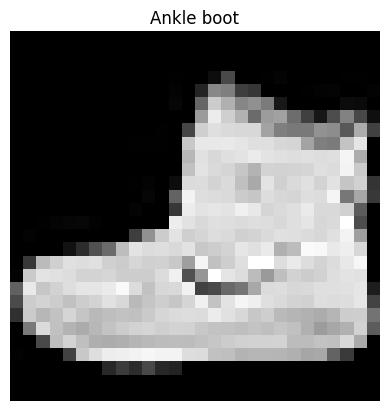

In [56]:
#plt.imshow(image.view(28, 28), cmap="grey") # works too, but squeeze is better
plt.imshow(image.squeeze(), cmap="grey")
plt.title(class_names[label])
plt.axis(False)


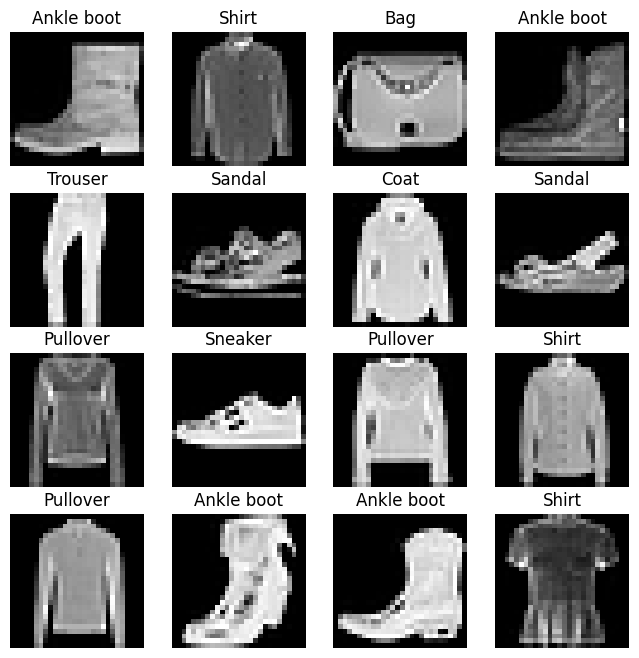

In [57]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(8, 8))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Right now our data are in the form of PyTorch tensors. A DataLoader turns our dataset into a Python iterables.

We want to turn our data into batches (or mini-batches).

Why?

1. It is computationally more efficient, as our HW is most likely not able to store 60000 images in memory. So we break it down to 32 images at a time (batch size of 32).
2. It gives out neural network more chances to updates its gradients per epoch.

In [58]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Train datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x33356eea0>,
 <torch.utils.data.dataloader.DataLoader at 0x33356fb30>)

In [59]:
# Let's check what we have created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} of {BATCH_SIZE}.")
print(f"Length of test dataloader: {len(test_dataloader)} of {BATCH_SIZE}.")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x33356eea0>, <torch.utils.data.dataloader.DataLoader object at 0x33356fb30>)
Length of train dataloader: 1875 of 32.
Length of test dataloader: 313 of 32.


In [60]:
# Check out what is inside the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


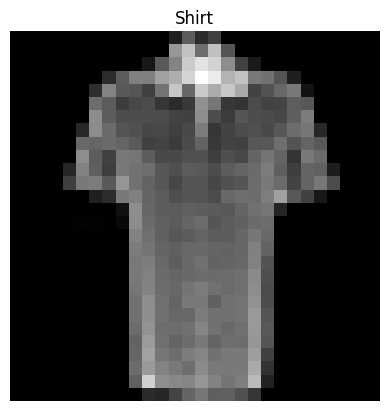

In [61]:
# Show a saple
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

Best practice in ML is to start with a base model, which you improve on with subsequent models/experiments. Start simple and introduce complexity as necessary.

In [62]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

# Print out what is happening
print(f"Shape before flattening: {x.shape}")
print(f"Shape before flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape before flattening: torch.Size([1, 784])


In [63]:
class FashionMNISTModel0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [64]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModel0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [65]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup a loss function, optimizer and evaluation metrics

* Loss function - since we are working with multiclass data our loss function will be `nn.CrossEntropyLess()`
* Optimizer - our optimizer `torch.optim.SGD()`
* Evaluation metric - since we are working on an classification problem, let's use accuracy as our metric

In [66]:
#Download helper function from Learn Pytorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download.


In [67]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our expertiments

ML is very experimental.

Two of the main things we often want to track:
1. Model's performance (loss, accuracy etc)
2. How fast model runs.


In [68]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
    """
    Prints difference between start time and end time. 
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} in seconds.")
    return total_time

In [69]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 in seconds.


1.7875005141831934e-05

### 3.3 Creating a training loop and training on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening. 
5. Time it all.

In [70]:
# import tqdm for progress bar
from tqdm import tqdm, trange

# Set the seed and start timer
torch.manual_seed(42)
train_time_on_cpu = timer()

# Set the number of epochs. Low number for faster training time.
epochs = 3

# Create training and test loop
for epoch in trange(epochs): #trange(x) same as tqdm(range(x))
    print(f"Epoch: {epoch}\n------")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # 1. Forward pass
        y_pred = model_0(X)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Backpropagation
        loss.backward()
        # 4. Optimizer step
        optimizer.step()
        
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
        
    # Divide total train loss by length by length of train dataloader.
    train_loss /= len(train_dataloader)
    
    ### Testing loop
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss and accuract average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    # Print out what is happening
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    
# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))           

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cpu: 3.860 in seconds.


## 4. Make predictions and get Model_0 results

In [74]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, 
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [75]:
# Calculate model_0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader, 
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn,
                             device="cpu")
model_0_results

100%|██████████| 313/313 [00:00<00:00, 1871.82it/s]


{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Model 1: Building a better model with non-linearity.

In [21]:
# Create a model with linear and non-linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [22]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### 6.1 Setup a loss function, optimizer and evaluation metrics

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [24]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn, 
               device: torch.device = device):
    """Performs a training step with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    
    # Put model in training mode
    model.train()
    
    # Loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        #Move data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Backpropagation
        loss.backward()
        # 4. Optimizer step
        optimizer.step()
        
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.")
        
    # Divide total train loss and accuracy by length by length of train dataloader.
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    # Print out what is happening
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [25]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, 
               device: torch.device = device):
    """Performs a test step with model testing on data_loader"""
    # Initialise loss and acc
    test_loss, test_acc = 0, 0
    # Put model on evaluation mode
    model.eval()
    # Use inference mode
    with torch.inference_mode():
        # Loop through the test batches
        for X, y in test_dataloader:
            #Move data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss and accuract average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    # Print out what is happening
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

In [26]:
torch.manual_seed(42)

# Measure time
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")
    ### Training
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
            )
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model_1.parameters()).device))      

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.9564 | Test acc: 65.00%
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.78097 | Train acc: 71.94%
Test loss: 0.7261 | Test acc: 73.99%
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.67040 | Train acc: 75.94%
Test loss: 0.6901 | Test acc: 74.81%
Train time on mps:0: 11.600 in seconds.


In [27]:
total_train_time_model_1, total_train_time_model_0

(11.600155749998521, 4.016846250000526)

In [28]:
model_1_results = eval_model(model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn, 
                             device=device)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 793.67it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6900655031204224,
 'model_acc': 74.810303514377}

## 7. Model 2: Building a Convolutional Neural Network (CNN)

In [29]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, # 7 * 7 is the output shape of the second conv block
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x 

In [30]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

### 7.1 Stepping through `nn.Conv2d()`

In [31]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [32]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [33]:
torch.manual_seed(42)

# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass the test_image through the conv layer
conv_output = conv_layer(test_image)
conv_output

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [34]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d`

In [35]:
# Print out original image shape withoug unsqueeze
print(f"Test image oringal shape: {test_image.shape}")
print(f"Test image unsqueezed shape: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through the conv layer
test_image_conv = conv_layer(test_image.unsqueeze(0))
print(f"Shape after conv layer: {test_image_conv.shape}")

# Pass data through the max pool layer
test_image_conv_max = max_pool_layer(test_image_conv)
print(f"Shape after conv and max pool layers: {test_image_conv_max.shape}")

Test image oringal shape: torch.Size([3, 64, 64])
Test image unsqueezed shape: torch.Size([1, 3, 64, 64])
Shape after conv layer: torch.Size([1, 10, 62, 62])
Shape after conv and max pool layers: torch.Size([1, 10, 31, 31])


In [36]:
torch.manual_seed(42)

# Create a random tensor with similar dimensions to the FashionMNIST dataset
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_output = max_pool_layer(random_tensor)
print(f"Max pool tensor: {max_pool_output}")
print(f"Max pool tensor shape: {max_pool_output.shape}")
random_tensor

Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor: tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

### 7.3 Setup loss function and optimizer

In [37]:
# Setup loss function, optimizer and evaluation fuction
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

### 7.4 Training and testing `model_2` using our training and testing loop functions

In [38]:
torch.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

#Train and test model
epochs = 3
for epoch in trange(epochs):
    print(f"Epoch: {epoch}\n------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.59093 | Train acc: 78.58%


 33%|███▎      | 1/3 [00:06<00:12,  6.17s/it]

Test loss: 0.3934 | Test acc: 85.64%
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.36547 | Train acc: 86.80%


 67%|██████▋   | 2/3 [00:12<00:06,  6.11s/it]

Test loss: 0.3546 | Test acc: 86.92%
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.32907 | Train acc: 88.08%


100%|██████████| 3/3 [00:18<00:00,  6.10s/it]

Test loss: 0.3292 | Test acc: 87.82%
Train time on mps: 18.299 in seconds.


In [39]:
# Get model_2 results
model_2_results = eval_model(model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn, 
                             device=device)

model_2_results

100%|██████████| 313/313 [00:00<00:00, 607.69it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3291807472705841,
 'model_acc': 87.81948881789137}

## 8. Compare model results and training time

In [77]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModel0,0.476639,83.426518
1,FashionMNISTModelV1,0.690066,74.810304
2,FashionMNISTModelV2,0.329181,87.819489


In [78]:
# Add training times to compare_results
compare_results["train_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,train_time
0,FashionMNISTModel0,0.476639,83.426518,3.859979
1,FashionMNISTModelV1,0.690066,74.810304,11.600156
2,FashionMNISTModelV2,0.329181,87.819489,18.299027


Text(0, 0.5, 'Model')

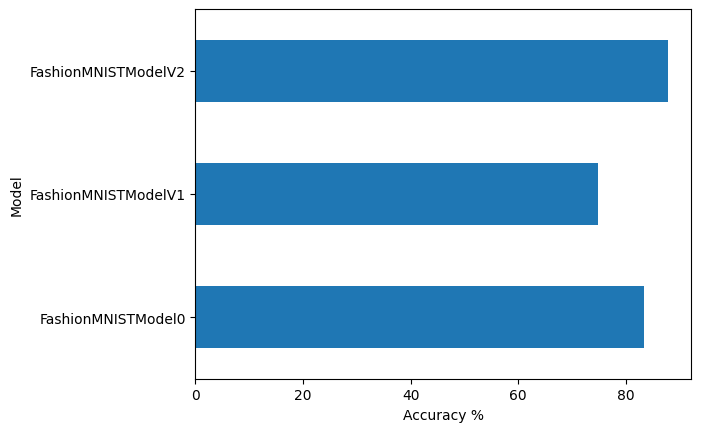

In [79]:
# Visualize the results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.ylabel("Model")

## 9. Make and evaluate random predictions with the best models

In [100]:
def make_predictions(model: torch.nn.Module,
                     data: list, 
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample (add batch dimension and move to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass
            pred_logit = model(sample)
            
            # Get prediction probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Get pred_prod off the GPU for further processing
            pred_probs.append(pred_prob.cpu())
            
        # Stack the pred_probs into a single tensor
        return torch.stack(pred_probs)

In [106]:
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

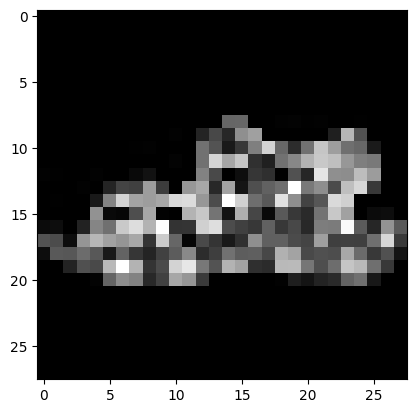

In [107]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")

In [108]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)

pred_probs[:2]

tensor([[2.7234e-06, 4.8793e-06, 4.4144e-06, 9.1462e-06, 1.0507e-05, 9.9917e-01,
         1.0055e-05, 4.3499e-04, 9.8664e-05, 2.5036e-04],
        [7.1478e-03, 1.1329e-05, 1.2833e-01, 8.2730e-05, 7.7281e-02, 4.1993e-06,
         7.8693e-01, 3.0862e-06, 1.9892e-04, 4.8773e-06]])

In [109]:
pred_prob_classes = pred_probs.argmax(dim=1)
pred_prob_classes

tensor([5, 6, 6, 6, 3, 1, 2, 3, 6])

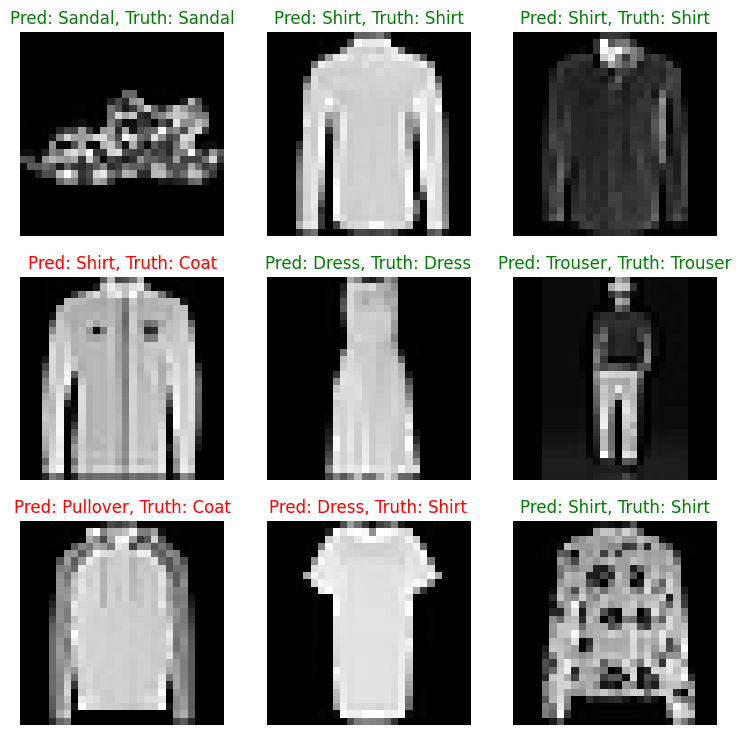

In [110]:
# Plot predictions
plt.figure(figsize=(9, 9))
ncols, nrows = 3, 3
for i, sample in enumerate(test_samples):
    # Create sublplot
    plt.subplot(nrows, ncols, i + 1)
    # Plot target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # Find the prediction class in text form
    pred_label = class_names[pred_prob_classes[i]]
    # Get the true label
    truth_label = class_names[test_labels[i]]
    # Set the title
    title_text = f"Pred: {pred_label}, Truth: {truth_label}"
    # Check for equality and color the title accordingly
    if pred_label == truth_label:
        plt.title(title_text, color="green")
    else:
        plt.title(title_text, color="red")
    
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a great way of evaluating a classification model visually.

1. Make predictions with the train model on our test datasets.
2. Make a confusion matrix with `torchmetrics.ConfusionMatrix`.
3. Plot the confusion matrix with `mlxtend.plotting.plot_confusion_matrix()`

In [112]:
# 1. Make predictions with the trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        # Move data to target device
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_logits = model_2(X)
        # Turn predictions logits into probabilities and labels
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        # Append prediction to list and move to CPU
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

100%|██████████| 313/313 [00:00<00:00, 468.35it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

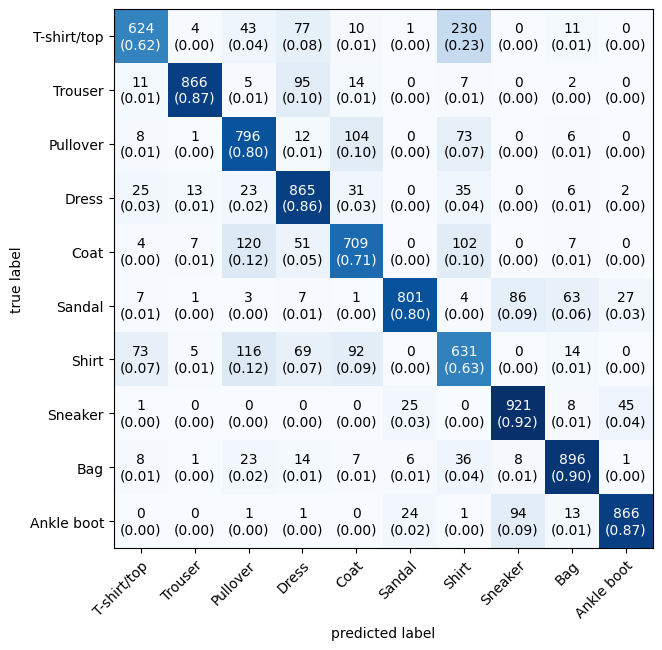

In [120]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
cm = ConfusionMatrix(num_classes=len(class_names),task="MULTICLASS")
cm_tensor = cm(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm_tensor.numpy(),
                                figsize=(10, 7),
                                class_names=class_names, 
                                show_normed=True)

## 11. Save and load best performing model

In [122]:
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True,
                 parents=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dictionary
print(f"Saving model state dict at: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model state dict at: models/03_pytorch_computer_vision_model_2.pth


In [123]:
# Create a new instance
torch.manual_seed(42)
model_2_loaded = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

# Load the model state dictionary  
model_2_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

/var/folders/yy/j3y_mcxx609fklcnx_s5nrhr0000gn/T/ipykernel_24764/1230671484.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2_loaded.load_state_dict(torch.load(MOD

<All keys matched successfully>

In [124]:
# Evaluate loaded model
torch.manual_seed(42)

model_2_loaded_results = eval_model(
    model = model_2_loaded,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn,
    device = device
)

model_2_loaded_results

100%|██████████| 313/313 [00:00<00:00, 599.35it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3291807472705841,
 'model_acc': 87.81948881789137}

In [128]:
# Check if loaded model results are the same as the original model
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(model_2_loaded_results["model_loss"]),
              atol=1e-1
)

tensor(True)